<a id='contents'></a>

## Libraries and global variables

In [1]:
# Libraries and packages

print('This notebook was prepared using:')

from importlib import reload
import sys, os
from copy import deepcopy
print('python version %s' % sys.version)

import numpy as np
print('numpy version %s' % np.__version__)

import scipy as sp
import scipy.stats as st
print('scipy version %s' % sp.__version__)

import pandas as pd
print('pandas version %s' % pd.__version__)

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
print('matplotlib version %s' % matplotlib.__version__)

This notebook was prepared using:
python version 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version 1.20.3
scipy version 1.7.1
pandas version 1.3.4
matplotlib version 3.4.3


### EM algorithm and smoothing

In [2]:
# EM steps

def get_em_lambda(f,   # incubation time distribution, a data frame with columns dt and weight
                  Y,   # observations, a data frame with columns times and counts
                  lam  # infection rates, a data frame with columns times and rates
                  ):
    
    lam_star = lam.copy(deep=True)
    times = lam['times']
    times_dt = f['dt']
    
    for idx in range(len(lam)):
        
        # time for the current lambda value
        t_lam = lam.loc[idx, 'times']
        
        lam_temp = 0
        f_norm   = 0
        for dt in times_dt:
            if (t_lam+dt) not in Y['times'].values:
                continue
                
#             if len(Y[Y['times']==t_lam+dt])!=1:
#                 print('idx %d\tt_lam %d\tdt %d' % (idx, t_lam, dt))
#                 print('lam_t %.2e\tf_dt %.2e' % (float(lam[lam['times']==t_lam]['rates']), 
#                                                  float(f[f['dt']==dt]['weight'])))
#                 print('Y at t=t_lam+dt:')
#                 print(Y[Y['times']==t_lam+dt])
#                 print((t_lam+dt) in Y['times'])
            
            Y_tdt = Y[Y['times']==t_lam+dt]['counts'].values[0]  # observations at t + dt
            lam_t = lam[lam['times']==t_lam]['rates'].values[0]  # rate at t
            f_dt  = f[f['dt']==dt]['weight'].values[0]           # incubation prob at dt
            
            #print(idx, t_lam, dt, Y_tdt, lam_t, f_dt)
            
            f_norm += f_dt
            
            # no contribution to lambda* when any of above are zero
            num = Y_tdt * lam_t * f_dt
            if num==0:
                continue
            
            denom = 0
            for t in times:
                ddt = t_lam+dt-t
                if ddt in f['dt']:
                    denom += lam[lam['times']==t]['rates'].values[0] * f[f['dt']==ddt]['weight'].values[0]
    
            lam_temp += num/denom
        
        if f_norm>0:
            lam_star.loc[idx, 'rates'] = lam_temp/f_norm
            
        else:
            lam_star.loc[idx, 'rates'] = 0
        
    return lam_star

In [3]:
# smoothing

def get_smooth_lambda(w,   # smoothing function, a data frame with columns dt and weight
                      lam # infection rates, a data frame with columns times and rates
                      ):
    
    lam_smooth = lam.copy(deep=True)
    times = lam['times']
    times_dt = w['dt']
    
    for idx in range(len(lam)):
    
        # time for the current lambda value
        t_lam = lam.loc[idx, 'times']
        
        lam_temp = 0
        w_norm   = 0
        for dt in times_dt:
            if (t_lam+dt) not in lam['times'].values:
                continue
            
            lam_tdt = lam[lam['times']==t_lam+dt]['rates'].values[0]  # rate at t + dt
            w_dt    = w[w['dt']==dt]['weight'].values[0]              # smoothing weight at dt
            
            lam_temp += lam_tdt * w_dt
            w_norm   += w_dt
            
        if w_norm>0:
            lam_smooth.loc[idx, 'rates'] = lam_temp/w_norm
        
        else: 
            lam_smooth.loc[idx, 'rates'] = 0
        
    return lam_smooth

### Reading in data and quality checks (no array overruns, etc.)

In [4]:
incubation_file = 'example_incubation_time.csv'
smoothing_file = 'example_smoothing_weights.csv'
observation_file = 'example_timeseries.csv'
output_file = observation_file.split('.')[0] + '_rates.csv'

df_inc = pd.read_csv(incubation_file, memory_map=True)
df_smooth = pd.read_csv(smoothing_file, memory_map=True)
df_obs = pd.read_csv(observation_file, memory_map=True)

# expand indices such that observations (and lambda extend +/- dt around current boundaries)
dt_min = np.min([np.min(df_inc['dt']), 0]) + np.min([np.min(df_smooth['dt']), 0])
dt_max = np.max([np.max(df_inc['dt']), 0]) + np.max([np.max(df_smooth['dt']), 0])

t_min = np.min(df_obs['times']) + dt_min - 1
t_max = np.max(df_obs['times']) + dt_max + 1

for t in range(t_min, t_max+1):
    if t not in df_obs['times'].values:
        row = dict(times=t, counts=0)
        df_obs = pd.concat([df_obs, pd.DataFrame([row])], ignore_index=True)
        

# copy lambda data frame, uniform initialization
df_lam = df_obs.copy(deep=True)
df_lam['rates'] = 1/float(len(df_lam))

# lam_uniform = 1/float((t_max - dt_max) - (t_min - dt_min)) # need smarter init b/w obs values?


# sanity checking
if np.min(df_smooth['weight'])<0:
    print('Smoothing function contains negative values!')

if np.min(df_inc['weight'])<0:
    print('Incubation time distribution contains negative values!')
    
if np.min(df_obs['counts'])<0:
    print('Counts file contains negative values!')
    
times = df_lam['times'].values
for t in times:
    n_rows = len(df_lam[df_lam['times']==t])
    if n_rows!=1:
        print('Got %d observation rows with time=%d!' % (n_rows, t))

### Run until convergence

In [5]:
# convergence conditions
max_iter = 250
min_dlam = 1e-4

# initial conditions
df_lam_init = df_lam.copy(deep=True)
df_lam_last = df_lam.copy(deep=True)
curr_iter   = 0

print('iter\tepsilon')

while True:
    curr_iter += 1
    
    df_lam = get_em_lambda(f=df_inc, Y=df_obs, lam=df_lam_last)
    df_lam = get_smooth_lambda(w=df_smooth, lam=df_lam)
    
    curr_lam = np.array(df_lam['rates'])
    last_lam = np.array(df_lam_last['rates'])
    
    eps = np.sum(np.absolute(curr_lam - last_lam)) / np.sum(last_lam)
    
    print('%d\t%.2e' % (curr_iter, eps))
    
    df_lam_last = df_lam
    
    if (curr_iter>=max_iter) or (eps<=min_dlam):
        break
        
df_lam_last.sort_values(by=['times'], inplace=True)
df_lam_last.to_csv(output_file)

iter	epsilon
1	1.22e+01
2	4.38e-02
3	1.02e-02
4	2.85e-03
5	8.17e-04
6	2.35e-04
7	6.75e-05


### Visualize the result

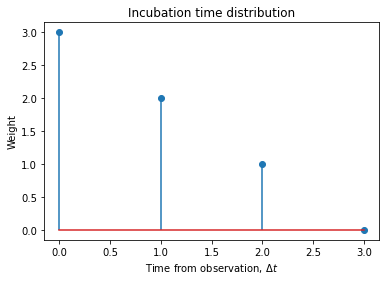

In [6]:
import matplotlib.pyplot as plt

dt = df_inc['dt'].values
w  = df_inc['weight'].values

xs, ys = zip(*sorted(zip(dt, w)))
plt.stem(xs, ys)
plt.xlabel(r'Time from observation, $\Delta t$')
plt.ylabel('Weight')
plt.title('Incubation time distribution')
plt.show()

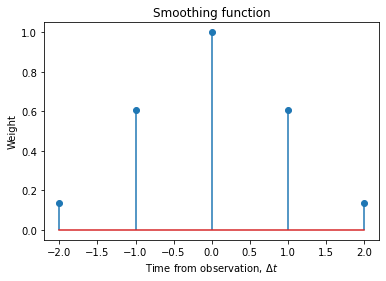

In [7]:
import matplotlib.pyplot as plt

dt = df_smooth['dt'].values
w  = df_smooth['weight'].values

xs, ys = zip(*sorted(zip(dt, w)))
plt.stem(xs, ys)
plt.xlabel(r'Time from observation, $\Delta t$')
plt.ylabel('Weight')
plt.title('Smoothing function')
plt.show()

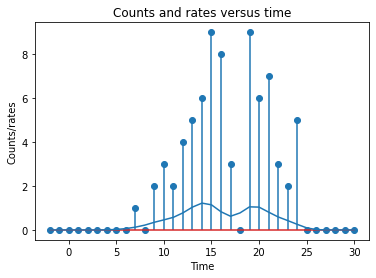

In [8]:
import matplotlib.pyplot as plt

t   = df_lam_last['times'].values
obs = df_lam_last['counts'].values
lam = df_lam_last['rates'].values 

# for i in range(len(t)):
#     print('%d\t%.2f' % (t[i], lam[i]))

xs, ys = zip(*sorted(zip(t, obs)))
plt.stem(xs, ys, label='observations')

xs, ys = zip(*sorted(zip(t, lam)))
plt.plot(xs, ys, label='rates')

plt.xlabel(r'Time')
plt.ylabel('Counts/rates')
plt.title('Counts and rates versus time')
plt.show()